#################################################### Importing Libraries ####################################################

In [1]:
!pip install import_ipynb
!pip install -U -q PyDrive
!pip install pytorch_pretrained_bert
!pip install sparse
!pip install transformers
!pip install torchmetrics
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
2.1.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip

In [2]:
!pip install einops


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.

import torch
from torch_geometric.data import Data

import numpy as np
import sparse

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as tgmnn
from torch_geometric.nn import global_mean_pool
from torch_geometric.loader import DataListLoader as GraphLoader
from torch_geometric.data import Batch

from torch.nn import TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
import time
from sklearn import preprocessing
import math
from torch.utils.data import Dataset
import copy
import sklearn.metrics as skm
import pandas as pd
import random
from torch.utils.data.dataset import Dataset
import pytorch_pretrained_bert as Bert
import itertools
from einops import rearrange, repeat

import ast
from typing import Optional, Tuple, Union
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import Adj, OptTensor, PairTensor, SparseTensor
from torch_geometric.utils import softmax
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import LayerNorm
import torch.nn.functional as F
from torch import Tensor

from sklearn.model_selection import ShuffleSplit
import pickle
from matplotlib import pyplot as plt
from tqdm import tqdm

/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_geometric/typing.py:63: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: dlopen(/Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so, 0x0006): Symbol not found: __ZN5torch8autograd13_wrap_outputsERKNSt3__16vectorIN2at6TensorENS1_9allocatorIS4_EEEERKNS1_13unordered_setIPN3c1010TensorImplENS1_4hashISD_EENS1_8equal_toISD_EENS5_ISD_EEEESL_NSB_8ArrayRefINSB_8optionalIS4_EEEERKNS1_10shared_ptrINS0_4NodeEEENS1_8functionIFS7_S7_S7_EEE
  Referenced from: <BEF9F452-9D77-323E-91B8-AF667F303838> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch_scatter/_scatter_cpu.so
  Expected in:     <66FB8649-BB87-3CD6-A177-462038DCAE02> /Users/garance/.pyenv/versions/3.11.5/envs/projet_AMAL/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib
  warnings.warn(f"An issue 

#################################################### Importing Data ####################################################

In [4]:
#######################################################################################################################################

'''
chemin = "../Tests_donnees/"

# ouvrir un fichier pickle en mode lecture
with open(chemin + "dic_global_reverse.pkl", "rb") as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    dic = mon_depickler.load()
    
#print(dic.keys())

nb_nodes = len(dic)+5
print(nb_nodes)
'''
#######################################################################################################################################

'\nchemin = "../Tests_donnees/"\n\n# ouvrir un fichier pickle en mode lecture\nwith open(chemin + "dic_global_reverse.pkl", "rb") as fichier:\n    mon_depickler = pickle.Unpickler(fichier)\n    dic = mon_depickler.load()\n    \n#print(dic.keys())\n\nnb_nodes = len(dic)+5\nprint(nb_nodes)\n'

#################################################### Defining classes ####################################################

In [5]:
#######################################################################################################################################
###################################################### Transformer Conv ###############################################################
#######################################################################################################################################

class TransformerConv(MessagePassing):
    _alpha: OptTensor
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        beta: bool = False,
        dropout: float = 0.,
        edge_dim: Optional[int] = None,
        bias: bool = True,
        root_weight: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.beta = beta and root_weight
        self.root_weight = root_weight
        self.concat = concat
        self.dropout = dropout
        self.edge_dim = edge_dim
        self._alpha = None

        if isinstance(in_channels, int):
            in_channels = (in_channels, in_channels)

        self.lin_key = Linear(in_channels[0], heads * out_channels)
        self.lin_query = Linear(in_channels[1], heads * out_channels)
        self.lin_value = Linear(in_channels[0], heads * out_channels)
        self.layernorm1 = LayerNorm(out_channels)
        self.layernorm2 = LayerNorm(out_channels)
        self.gelu = nn.GELU()
        self.proj = Linear(heads * out_channels, out_channels)
        self.ffn = Linear(out_channels, out_channels)
        self.ffn2 = Linear(out_channels, out_channels)
        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False)
        else:
            self.lin_edge = self.register_parameter('lin_edge', None)


        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        self.lin_key.reset_parameters()
        self.lin_query.reset_parameters()
        self.lin_value.reset_parameters()
        if self.edge_dim:
            self.lin_edge.reset_parameters()


    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, batch=None, return_attention_weights=None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""Runs the forward pass of the module.

        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels
        residual = x
        x = self.layernorm1(x, batch)
        if isinstance(x, Tensor):
            x: PairTensor = (x, x)
        query = self.lin_query(x[1]).view(-1, H, C)
        key = self.lin_key(x[0]).view(-1, H, C)
        value = self.lin_value(x[0]).view(-1, H, C)
        # propagate_type: (query: Tensor, key:Tensor, value: Tensor, edge_attr: OptTensor) # noqa
        out = self.propagate(edge_index, query=query, key=key, value=value,
                             edge_attr=edge_attr, size=None)
        alpha = self._alpha
        self._alpha = None
        if self.concat:
            out = self.proj(out.view(-1, self.heads * self.out_channels))
        else:
            out = out.mean(dim=1)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out+residual
        residual = out

        out = self.layernorm2(out)
        out = self.gelu(self.ffn(out))
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.ffn2(out)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = out + residual
        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, query_i: Tensor, key_j: Tensor, value_j: Tensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:


        if self.lin_edge is not None:
            assert edge_attr is not None
            edge_attr = self.lin_edge(edge_attr).view(-1, self.heads,
                                                      self.out_channels)
            key_j = key_j + edge_attr

        alpha = (query_i * key_j).sum(dim=-1) / math.sqrt(self.out_channels)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        out = value_j
        if edge_attr is not None:
            out = out + edge_attr

        out = out * alpha.view(-1, self.heads, 1)
        return out

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [6]:
#######################################################################################################################################
###################################################### Graph Transformer ###############################################################
#######################################################################################################################################

class GraphTransformer(torch.nn.Module):
    def __init__(self, config):
        super().__init__()
        
        self.transformerconv1 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv2 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=True)
        self.transformerconv3 = TransformerConv(config.hidden_size // 5, config.hidden_size // 5, heads=2, edge_dim=config.hidden_size // 5, dropout=config.hidden_dropout_prob, concat=False)
        
        self.embed = nn.Embedding(config.vocab_size, config.hidden_size // 5) 
        self.embed_ee = nn.Embedding(config.node_attr_size, config.hidden_size // 5)
                    

    def forward(self, x, edge_index, edge_index_readout, edge_attr, batch):
        #print("GT")
        indices = (x==0).nonzero().squeeze()
        h_nodes = self.transformerconv1(x=self.embed(x), edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv2(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        h_nodes = nn.GELU()(h_nodes)
        h_nodes = self.transformerconv3(x=h_nodes, edge_index=edge_index, edge_attr=self.embed_ee(edge_attr), batch=batch)
        x = h_nodes[indices]
        return x, h_nodes

In [7]:
#######################################################################################################################################
######################################################## Bert Config ##################################################################
#######################################################################################################################################

class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super(BertConfig, self).__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings = config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.age_vocab_size = config.get('age_vocab_size')
        self.type_vocab_size = config.get('type_vocab_size')
        self.time_vocab_size = config.get('time_vocab_size')
        self.graph_dropout_prob = config.get('graph_dropout_prob')
        self.node_attr_size = config.get('node_attr_size')
        

In [8]:
class Pre_training_1(nn.Module):
    def __init__(self, config):
        super(Pre_training_1, self).__init__()
        self.config = config
        self.gnn = GraphTransformer(config)
        self.linear = nn.Linear(self.config.hidden_size // 5, self.config.vocab_size)
        self.layers = nn.ModuleList([self.gnn, self.linear])

    def forward(self, nodes, edge_index, edge_index_readout, edge_attr, batch):
        # Define the forward pass using self.gnn and self.linear as needed
        vst,x = self.gnn(nodes, edge_index, edge_index_readout, edge_attr, batch)
        x = self.linear(x)
        return x

In [9]:
#######################################################################################################################################
############################################################ GDSet ####################################################################
#######################################################################################################################################

class GDSet(Dataset):
    def __init__(self, g):
        self.g = g

    def __getitem__(self, index):

        g = self.g[index]
        for i in range(len(g)):
          g[i]['posi_ids'] = i
        return g

    def __len__(self):
        return len(self.g)

#################################################### Importing Data ######################################################

In [10]:
path = '../../data/'
path_results = '../../results/'

In [12]:
with open(path + 'data_pad100.pkl', 'rb') as handle:
    dataset = pickle.load(handle)

##################################################### Splitting Data ######################################################

In [19]:
#######################################################################################################################################
pourcentage_nodes_to_mask = 0.15
labels_masked_nodes = []
mask_node_embeddings = 2

In [20]:
def split_dataset(dataset, train_params, random_seed=1):
  rs = ShuffleSplit(n_splits=1, test_size=train_params.get('test_split'), random_state=random_seed)

  for i, (train_index_tmp, test_index) in enumerate(rs.split(dataset)):
    rs2 = ShuffleSplit(n_splits=1, test_size=train_params.get('val_split'), random_state=random_seed)
    
    for j, (train_index, val_index) in enumerate(rs2.split(train_index_tmp)):
      train_index = train_index_tmp[train_index]
      val_index = train_index_tmp[val_index]
      trainDSet = [dataset[x] for x in train_index]
      valDSet = [dataset[x] for x in val_index]
      testDSet = [dataset[x] for x in test_index]

      return trainDSet, valDSet, testDSet

###################################################### Config Files ######################################################

In [34]:
train_params = {
    'batch_size': 5,
    'max_len_seq': 50,
    'device': "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"),
    'data_len' : len(dataset),
    'val_split' : 0.1,
    'test_split' : 0.2,
    'train_data_len' : int(0.9*0.8*len(dataset)),   # the train dataset is 90% of 80% of the whole dataset
    'val_data_len' : int(0.1*0.8*len(dataset)),   # the validation dataset is 10% of 80% of the whole dataset
    'test_data_len' : int(0.2*len(dataset)),   # the test dataset is 20% of the whole dataset
    'epochs' : 20,
    'lr': 0.0001,
    'weight_decay': 0.0001
}

model_config = {
    'vocab_size': 9405, # number of disease + symbols for word embedding (avec vst) + 1 for mask
    'edge_relationship_size': 8, # number of vocab for edge_attr
    'hidden_size': 50*5, # word embedding and seg embedding hidden size
    'seg_vocab_size': 2, # number of vocab for seg embedding
    'age_vocab_size': 151, # number of vocab for age embedding
    'time_vocab_size': 380, # number of vocab for time embedding
    'type_vocab_size': 11+1, # number of vocab for type embedding + 1 for mask
    'node_attr_size': 8, # number of vocab for node_attr embedding
    'num_labels':1,
    'max_position_embedding': 50, # maximum number of tokens
    'hidden_dropout_prob': 0.2, # dropout rate
    'graph_dropout_prob': 0.2, # dropout rate
    'num_hidden_layers': 6, # number of multi-head attention layers required
    'num_attention_heads': 2, # number of attention heads
    'attention_probs_dropout_prob': 0.2, # multi-head attention dropout rate
    'intermediate_size': 512, # the size of the "intermediate" layer in the transformer encoder
    'hidden_act': 'gelu', # The non-linear activation function in the encoder and the pooler "gelu", 'relu', 'swish' are supported
    'initializer_range': 0.02, # parameter weight initializer range
    'n_layers' : 3 - 1,
    'alpha' : 0.1
}

######################################################## CUDA ##########################################################

In [35]:
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# print which device is used
print('device: ', train_params['device'])

device:  cpu


#################################################### Training Functions ####################################################

In [36]:
print(len(vars))
print(type(vars))
print(vars[-1].shape)

55
<class 'list'>
torch.Size([9405])


In [47]:
def train(model, optim, trainload, device):
    tr_loss = 0
    start = time.time()
    model.train()
    
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    for step, data in tqdm(enumerate(trainload)):
        optim.zero_grad()

        batched_data = Batch()
        graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
        graph_batch = graph_batch.to(device)
        nodes = graph_batch.x
                
        list_index = [i for i in range(nodes.shape[0])]
        random.shuffle(list_index)
        index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
        index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
        labels_nodes = nodes
        ytrue = nodes

        labels_nodes[index_nodes_not_masked] = 3
        nodes[index_nodes_to_mask] = mask_node_embeddings
        
        edge_index = graph_batch.edge_index
        edge_index_readout = graph_batch.edge_index
        edge_attr = graph_batch.edge_attr
        batch = graph_batch.batch

        pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)
        
        loss = CE_loss(pred, labels_nodes)
        loss.backward()
        tr_loss += loss.item()
        optim.step()

        del loss

    print("TOTAL TRAIN LOSS", (tr_loss * train_params['batch_size']) / len(trainload))
    cost = time.time() - start
    return tr_loss, cost, pred,ytrue

In [48]:
def eval(model, _valload, device):
    tr_loss = 0
    start = time.time()
    model.eval()
    CE_loss = torch.nn.CrossEntropyLoss(ignore_index=3)
    
    with torch.no_grad():
        for step, data in tqdm(enumerate(_valload)):
            batched_data = Batch()
            graph_batch = batched_data.from_data_list(list(itertools.chain.from_iterable(data)))
            graph_batch = graph_batch.to(device)
            nodes = graph_batch.x
                    
            list_index = [i for i in range(nodes.shape[0])]
            random.shuffle(list_index)
            index_nodes_to_mask = list_index[:int((nodes.shape[0]) * pourcentage_nodes_to_mask)]
            index_nodes_not_masked = list(set(list_index) - set(index_nodes_to_mask))
            labels_nodes = nodes
            ytrue = nodes
            
            labels_nodes[index_nodes_not_masked] = 3
            nodes[index_nodes_to_mask] = mask_node_embeddings
            
            edge_index = graph_batch.edge_index
            edge_index_readout = graph_batch.edge_index
            edge_attr = graph_batch.edge_attr
            batch = graph_batch.batch

            pred = model(nodes, edge_index, edge_index_readout, edge_attr, batch)

            loss = CE_loss(pred, labels_nodes)
            tr_loss += loss.item()
            
            del loss

    print("TOTAL EVAL LOSS", (tr_loss * train_params['batch_size']) / len(_valload))

    cost = time.time() - start
    return tr_loss, cost, pred, ytrue

In [49]:
def run_epoch(model, optim_model, trainload, valload, device, exp):
    best_val = math.inf
    loss_train_liste = []
    loss_val_liste = []
    
    for e in tqdm(range(train_params["epochs"])):
        print("Epoch n" + str(e))
        train_loss, train_time_cost, pred_train, ytrue_train = train(model, optim_model, trainload, device)
        val_loss, val_time_cost, pred_eval, ytrue_eval = eval(model, valload, device)
        accuracy_train = skm.accuracy_score(ytrue_train.cpu().detach().numpy(), pred_train.cpu().detach().numpy().argmax(axis=1))
        accuracy_eval = skm.accuracy_score(ytrue_eval.cpu().detach().numpy(), pred_eval.cpu().detach().numpy().argmax(axis=1))

        train_loss = (train_loss * train_params['batch_size']) / len(trainload)
        val_loss = (val_loss * train_params['batch_size']) / len(valload)
        loss_train_liste.append(train_loss)
        loss_val_liste.append(val_loss)
        print('TRAIN \t{} secs'.format(train_time_cost))
        print(f'TRAIN accuracy : {accuracy_train}')
        
        with open(path_results + 'losses_and_times/' + "pre_training_1_log_train_" + f'{exp}' + ".txt", 'a') as f:
            f.write("Epoch n" + str(e) + '\n TRAIN {}\t{} secs\n'.format(train_loss, train_time_cost))
            f.write('EVAL {}\t{} secs\n'.format(val_loss, val_time_cost) + '\n\n\n')
        print('EVAL \t{} secs'.format(val_time_cost))
        print('EVAL accuracy : {}\n\n'.format(accuracy_eval))
        
        if val_loss < best_val:
            print("** ** * Saving fine - tuned model ** ** * ")
            torch.save(model.gnn.state_dict(), path_results + 'weights/' + 'GraphTransformer_pretrain_1_num_' + f'{exp}' + '.pch')
            best_val = val_loss
            
    epoch = [i for i in range(train_params["epochs"])]
    plt.plot(epoch, loss_train_liste)
    plt.legend(['train'])
    plt.plot(epoch,loss_val_liste)
    plt.legend(['val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig(path_results + 'plots/' + 'Pre_training_1.png')
    plt.show()

    return train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost

################################################### Experiences ####################################################

In [58]:
def experiment(num_experiments=5):
    conf = BertConfig(model_config)
    df = pd.DataFrame(columns=['Experiment', 'Model', 'Metric', 'Score'])

    for exp in tqdm(range(num_experiments)):
        model = Pre_training_1(conf).to(train_params['device'])
        transformer_vars = [i for i in model.parameters()]
        optim_model = torch.optim.AdamW(transformer_vars, lr=train_params['lr'], weight_decay=train_params['weight_decay'])
    
        print(f"\n Experiment {exp + 1}")
        trainDSet, valDSet, testDSet = split_dataset(dataset, train_params, random_seed=exp)
        trainload =  GraphLoader(GDSet(trainDSet), batch_size=train_params['batch_size'], shuffle=False) 
        valload =  GraphLoader(GDSet(valDSet), batch_size=train_params['batch_size'], shuffle=False)

        #pretrain à ajouter ici
        train_loss, val_loss, accuracy_train, accuracy_eval, train_time_cost, val_time_cost = run_epoch(model, optim_model, trainload, valload, train_params['device'], exp)

        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Accuracy', accuracy_eval]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Loss', train_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Loss', val_loss]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Train Time', train_time_cost]
        df.loc[len(df)] = [exp + 1, 'GT_BERT', 'Val Time', val_time_cost]
        
    df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1.csv')

    return df

######################################################## Main #########################################################

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

2it [00:00, 11.95it/s]


 Experiment 1
Epoch n0




4it [00:00, 12.22it/s]

6it [00:00, 12.50it/s]

8it [00:00, 12.24it/s]

10it [00:00, 11.15it/s]

12it [00:00, 12.44it/s]

15it [00:01, 12.56it/s]


2it [00:00, 43.79it/s][A

  5%|▌         | 1/20 [00:01<00:23,  1.25s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 46.66626707712809
TOTAL EVAL LOSS 44.56988573074341
TRAIN 	1.1956050395965576 secs
TRAIN accuracy : 0.0
EVAL 	0.04672098159790039 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




2it [00:00, 12.90it/s]

4it [00:00, 12.88it/s]

6it [00:00, 13.23it/s]

8it [00:00, 13.22it/s]

10it [00:00, 11.96it/s]

12it [00:00, 13.27it/s]

15it [00:01, 13.31it/s]


2it [00:00, 46.35it/s][A

 10%|█         | 2/20 [00:02<00:22,  1.23s/it]

0it [00:00, ?it/s]

2it [00:00, 14.14it/s]

TOTAL TRAIN LOSS 42.741459687550865
TOTAL EVAL LOSS 40.62490940093994
TRAIN 	1.1284098625183105 secs
TRAIN accuracy : 0.0
EVAL 	0.04413199424743652 secs
EVAL accuracy : 0.004228329809725159


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 14.24it/s]

6it [00:00, 14.25it/s]

8it [00:00, 13.83it/s]

10it [00:00, 12.33it/s]

12it [00:00, 13.67it/s]

15it [00:01, 13.74it/s]


2it [00:00, 38.22it/s][A

 15%|█▌        | 3/20 [00:03<00:20,  1.21s/it]

0it [00:00, ?it/s]

1it [00:00,  9.72it/s]

TOTAL TRAIN LOSS 38.702775160471596
TOTAL EVAL LOSS 36.803730726242065
TRAIN 	1.0931439399719238 secs
TRAIN accuracy : 0.06805708013172337
EVAL 	0.05336189270019531 secs
EVAL accuracy : 0.08668076109936575


** ** * Saving fine - tuned model ** ** * 
Epoch n3




3it [00:00, 10.31it/s]

5it [00:00, 11.08it/s]

7it [00:00, 11.04it/s]

9it [00:00, 11.30it/s]

10it [00:00,  9.39it/s]

12it [00:01, 10.58it/s]

15it [00:01, 11.53it/s]


2it [00:00, 34.60it/s][A

 20%|██        | 4/20 [00:04<00:20,  1.25s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 34.3411029179891
TOTAL EVAL LOSS 32.221983671188354
TRAIN 	1.3022241592407227 secs
TRAIN accuracy : 0.12623490669593854
EVAL 	0.05901789665222168 secs
EVAL accuracy : 0.09513742071881606


** ** * Saving fine - tuned model ** ** * 
Epoch n4




2it [00:00, 12.42it/s]

4it [00:00, 12.48it/s]

6it [00:00, 12.62it/s]

8it [00:00, 12.64it/s]

10it [00:00, 11.59it/s]

12it [00:00, 12.98it/s]

15it [00:01, 12.78it/s]


2it [00:00, 39.28it/s][A

 25%|██▌       | 5/20 [00:06<00:18,  1.25s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 29.491711457570393
TOTAL EVAL LOSS 26.53027653694153
TRAIN 	1.1745448112487793 secs
TRAIN accuracy : 0.132821075740944
EVAL 	0.05192899703979492 secs
EVAL accuracy : 0.09725158562367865


** ** * Saving fine - tuned model ** ** * 
Epoch n5




2it [00:00, 12.99it/s]

4it [00:00, 13.07it/s]

6it [00:00, 13.55it/s]

8it [00:00, 13.48it/s]

10it [00:00, 12.09it/s]

12it [00:00, 13.46it/s]

15it [00:01, 13.53it/s]


2it [00:00, 44.72it/s][A

 30%|███       | 6/20 [00:07<00:17,  1.22s/it]

0it [00:00, ?it/s]



TOTAL TRAIN LOSS 23.61563714345296
TOTAL EVAL LOSS 22.250627279281616
TRAIN 	1.1095857620239258 secs
TRAIN accuracy : 0.12623490669593854
EVAL 	0.0460200309753418 secs
EVAL accuracy : 0.09725158562367865


** ** * Saving fine - tuned model ** ** * 
Epoch n6


2it [00:00, 14.31it/s]

4it [00:00, 14.48it/s]

6it [00:00, 14.56it/s]

8it [00:00, 14.04it/s]

10it [00:00, 12.10it/s]

12it [00:00, 13.44it/s]

15it [00:01, 13.64it/s]


2it [00:00, 41.40it/s][A

 35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

0it [00:00, ?it/s]

2it [00:00, 14.21it/s]

TOTAL TRAIN LOSS 17.572065273920696
TOTAL EVAL LOSS 14.683980345726013
TRAIN 	1.1018798351287842 secs
TRAIN accuracy : 0.13611416026344675
EVAL 	0.049345970153808594 secs
EVAL accuracy : 0.09936575052854123


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 14.14it/s]

6it [00:00, 13.90it/s]

8it [00:00, 13.65it/s]

10it [00:00, 12.14it/s]

12it [00:00, 13.45it/s]

15it [00:01, 13.55it/s]


2it [00:00, 46.32it/s][A

 40%|████      | 8/20 [00:09<00:14,  1.19s/it]

0it [00:00, ?it/s]

2it [00:00, 13.70it/s]

TOTAL TRAIN LOSS 13.792365312576294
TOTAL EVAL LOSS 14.345632791519165
TRAIN 	1.1081867218017578 secs
TRAIN accuracy : 0.13721185510428102
EVAL 	0.0441739559173584 secs
EVAL accuracy : 0.09513742071881606


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 13.69it/s]

6it [00:00, 13.93it/s]

8it [00:00, 13.58it/s]

10it [00:00, 12.14it/s]

12it [00:00, 13.44it/s]

15it [00:01, 13.50it/s]


2it [00:00, 45.82it/s][A

 45%|████▌     | 9/20 [00:10<00:13,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 14.04it/s]

TOTAL TRAIN LOSS 11.981176813443502
TOTAL EVAL LOSS 13.722577095031738
TRAIN 	1.112062931060791 secs
TRAIN accuracy : 0.12952799121844127
EVAL 	0.04470014572143555 secs
EVAL accuracy : 0.08879492600422834


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 14.17it/s]

6it [00:00, 14.33it/s]

8it [00:00, 14.00it/s]

10it [00:00, 12.52it/s]

12it [00:00, 13.91it/s]

15it [00:01, 13.97it/s]


2it [00:00, 48.83it/s][A

 50%|█████     | 10/20 [00:11<00:11,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 14.18it/s]

TOTAL TRAIN LOSS 10.400543491045633
TOTAL EVAL LOSS 11.450195908546448
TRAIN 	1.0749790668487549 secs
TRAIN accuracy : 0.14050493962678376
EVAL 	0.042112112045288086 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 14.17it/s]

6it [00:00, 14.37it/s]

8it [00:00, 14.15it/s]

10it [00:00, 12.53it/s]

12it [00:00, 13.86it/s]

15it [00:01, 13.99it/s]


2it [00:00, 44.35it/s][A

 55%|█████▌    | 11/20 [00:13<00:10,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 13.47it/s]

TOTAL TRAIN LOSS 10.21046131849289
TOTAL EVAL LOSS 12.463950514793396
TRAIN 	1.073462963104248 secs
TRAIN accuracy : 0.14489571899012074
EVAL 	0.04617190361022949 secs
EVAL accuracy : 0.14799154334038056


Epoch n11




4it [00:00, 13.60it/s]

6it [00:00, 13.80it/s]

8it [00:00, 13.63it/s]

10it [00:00, 12.14it/s]

12it [00:00, 13.38it/s]

15it [00:01, 13.54it/s]


2it [00:00, 47.53it/s][A

 60%|██████    | 12/20 [00:14<00:09,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 13.57it/s]

TOTAL TRAIN LOSS 9.760764499505362
TOTAL EVAL LOSS 9.46729600429535
TRAIN 	1.1085150241851807 secs
TRAIN accuracy : 0.14818880351262348
EVAL 	0.04308485984802246 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 13.71it/s]

6it [00:00, 13.94it/s]

8it [00:00, 13.71it/s]

10it [00:00, 12.12it/s]

12it [00:00, 13.43it/s]

15it [00:01, 13.54it/s]


2it [00:00, 41.20it/s][A

 65%|██████▌   | 13/20 [00:15<00:08,  1.16s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 9.106687247753143
TOTAL EVAL LOSS 10.194292962551117
TRAIN 	1.1085340976715088 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.049591064453125 secs
EVAL accuracy : 0.14799154334038056


Epoch n13




2it [00:00, 13.62it/s]

4it [00:00, 13.91it/s]

6it [00:00, 14.18it/s]

8it [00:00, 13.90it/s]

10it [00:00, 12.49it/s]

12it [00:00, 13.73it/s]

15it [00:01, 13.92it/s]


2it [00:00, 44.98it/s][A

 70%|███████   | 14/20 [00:16<00:06,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 14.13it/s]

TOTAL TRAIN LOSS 8.038825869560242
TOTAL EVAL LOSS 10.351517498493195
TRAIN 	1.078531265258789 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.04548978805541992 secs
EVAL accuracy : 0.14799154334038056


Epoch n14




4it [00:00, 14.22it/s]

6it [00:00, 14.40it/s]

8it [00:00, 14.08it/s]

10it [00:00, 12.51it/s]

12it [00:00, 13.85it/s]

15it [00:01, 14.02it/s]


2it [00:00, 48.36it/s][A

 75%|███████▌  | 15/20 [00:17<00:05,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 13.53it/s]

TOTAL TRAIN LOSS 7.597671627998352
TOTAL EVAL LOSS 7.308380305767059
TRAIN 	1.0713708400726318 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.042320966720581055 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n15




4it [00:00, 13.70it/s]

6it [00:00, 13.91it/s]

8it [00:00, 13.68it/s]

10it [00:00, 12.21it/s]

12it [00:00, 13.56it/s]

15it [00:01, 13.37it/s]


2it [00:00, 36.69it/s][A

 80%|████████  | 16/20 [00:18<00:04,  1.15s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 6.707571407159169
TOTAL EVAL LOSS 6.568104922771454
TRAIN 	1.1229820251464844 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.05554914474487305 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n16




2it [00:00, 12.43it/s]

4it [00:00, 12.48it/s]

6it [00:00, 12.74it/s]

8it [00:00, 12.35it/s]

10it [00:00, 11.24it/s]

12it [00:00, 12.38it/s]

15it [00:01, 12.30it/s]


2it [00:00, 37.40it/s][A

 85%|████████▌ | 17/20 [00:20<00:03,  1.19s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 5.449006060759227
TOTAL EVAL LOSS 4.989313036203384
TRAIN 	1.2207450866699219 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.05453801155090332 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n17




2it [00:00, 12.66it/s]

4it [00:00, 12.70it/s]

6it [00:00, 12.71it/s]

8it [00:00, 12.44it/s]

10it [00:00, 11.12it/s]

12it [00:00, 12.18it/s]

15it [00:01, 12.25it/s]


2it [00:00, 40.64it/s][A

 90%|█████████ | 18/20 [00:21<00:02,  1.22s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 3.8704635302225747
TOTAL EVAL LOSS 2.2202949970960617
TRAIN 	1.2251310348510742 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.0503239631652832 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n18




2it [00:00, 12.68it/s]

4it [00:00, 12.80it/s]

6it [00:00, 12.93it/s]

8it [00:00, 12.58it/s]

10it [00:00, 11.41it/s]

12it [00:00, 12.51it/s]

15it [00:01, 12.46it/s]


2it [00:00, 36.54it/s][A

 95%|█████████▌| 19/20 [00:22<00:01,  1.23s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 2.022865970929464
TOTAL EVAL LOSS 0.45497456565499306
TRAIN 	1.2050330638885498 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.05585289001464844 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 
Epoch n19




2it [00:00, 13.69it/s]

4it [00:00, 13.82it/s]

6it [00:00, 13.94it/s]

8it [00:00, 13.64it/s]

10it [00:00, 12.22it/s]

12it [00:00, 13.52it/s]

15it [00:01, 13.64it/s]


2it [00:00, 41.24it/s][A

100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


TOTAL TRAIN LOSS 0.739966860661904
TOTAL EVAL LOSS 0.08467605570331216
TRAIN 	1.100722074508667 secs
TRAIN accuracy : 0.14928649835345773
EVAL 	0.049577951431274414 secs
EVAL accuracy : 0.14799154334038056


** ** * Saving fine - tuned model ** ** * 


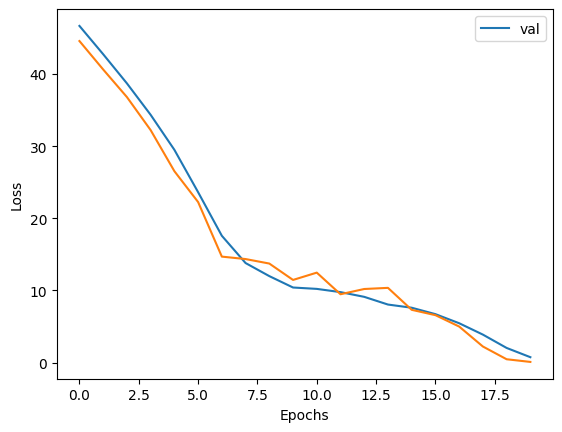

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 2
Epoch n0




2it [00:00, 14.09it/s]

4it [00:00, 14.82it/s]

6it [00:00, 14.43it/s]

8it [00:00, 14.92it/s]

10it [00:00, 12.64it/s]

12it [00:00, 13.19it/s]

15it [00:01, 14.48it/s]


2it [00:00, 44.47it/s][A

  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 16.61it/s]

TOTAL TRAIN LOSS 46.80507246653239
TOTAL EVAL LOSS 43.86143922805786
TRAIN 	1.0371711254119873 secs
TRAIN accuracy : 0.0
EVAL 	0.0460209846496582 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 16.72it/s]

6it [00:00, 15.77it/s]

8it [00:00, 16.01it/s]

10it [00:00, 13.25it/s]

12it [00:00, 13.67it/s]

15it [00:00, 15.02it/s]


2it [00:00, 45.24it/s][A

 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 14.75it/s]

TOTAL TRAIN LOSS 42.133727391560875
TOTAL EVAL LOSS 39.22281742095947
TRAIN 	0.9997639656066895 secs
TRAIN accuracy : 0.0
EVAL 	0.04517674446105957 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 15.09it/s]

6it [00:00, 14.68it/s]

8it [00:00, 15.22it/s]

10it [00:00, 13.04it/s]

12it [00:00, 13.27it/s]

15it [00:01, 14.56it/s]


2it [00:00, 44.77it/s][A

 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.12it/s]

TOTAL TRAIN LOSS 37.7552596728007
TOTAL EVAL LOSS 33.93115758895874
TRAIN 	1.031480073928833 secs
TRAIN accuracy : 0.06345177664974619
EVAL 	0.04567599296569824 secs
EVAL accuracy : 0.10583941605839416


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 16.34it/s]

6it [00:00, 15.42it/s]

8it [00:00, 15.55it/s]

10it [00:00, 13.06it/s]

12it [00:00, 13.36it/s]

15it [00:01, 14.64it/s]


2it [00:00, 45.46it/s][A

 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.41it/s]

TOTAL TRAIN LOSS 33.17662111918131
TOTAL EVAL LOSS 30.359779596328735
TRAIN 	1.0252947807312012 secs
TRAIN accuracy : 0.10152284263959391
EVAL 	0.045056819915771484 secs
EVAL accuracy : 0.10583941605839416


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 16.48it/s]

6it [00:00, 15.60it/s]

8it [00:00, 15.83it/s]

10it [00:00, 13.19it/s]

12it [00:00, 13.44it/s]

15it [00:01, 14.74it/s]


2it [00:00, 45.98it/s][A

 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.27it/s]

TOTAL TRAIN LOSS 27.954294840494793
TOTAL EVAL LOSS 23.889271020889282
TRAIN 	1.0187861919403076 secs
TRAIN accuracy : 0.10913705583756345
EVAL 	0.04461407661437988 secs
EVAL accuracy : 0.11131386861313869


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 16.49it/s]

6it [00:00, 15.60it/s]

8it [00:00, 15.92it/s]

10it [00:00, 13.26it/s]

12it [00:00, 13.66it/s]

15it [00:00, 15.06it/s]


2it [00:00, 45.88it/s][A

 30%|███       | 6/20 [00:06<00:14,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.55it/s]

TOTAL TRAIN LOSS 22.052766879399616
TOTAL EVAL LOSS 16.425456404685974
TRAIN 	0.9973301887512207 secs
TRAIN accuracy : 0.09644670050761421
EVAL 	0.0446321964263916 secs
EVAL accuracy : 0.10948905109489052


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 16.70it/s]

6it [00:00, 15.81it/s]

8it [00:00, 16.02it/s]

10it [00:00, 13.37it/s]

12it [00:00, 13.71it/s]

15it [00:00, 15.02it/s]


2it [00:00, 45.33it/s][A

 35%|███▌      | 7/20 [00:07<00:13,  1.06s/it]

0it [00:00, ?it/s]

2it [00:00, 16.38it/s]

TOTAL TRAIN LOSS 16.002097368240356
TOTAL EVAL LOSS 14.267222881317139
TRAIN 	0.9999878406524658 secs
TRAIN accuracy : 0.116751269035533
EVAL 	0.04535984992980957 secs
EVAL accuracy : 0.11131386861313869


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 16.36it/s]

6it [00:00, 15.52it/s]

8it [00:00, 15.68it/s]

10it [00:00, 13.03it/s]

12it [00:00, 13.31it/s]

15it [00:01, 14.69it/s]


2it [00:00, 43.91it/s][A

 40%|████      | 8/20 [00:08<00:12,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 15.88it/s]

TOTAL TRAIN LOSS 13.244287729263306
TOTAL EVAL LOSS 10.865206718444824
TRAIN 	1.0218589305877686 secs
TRAIN accuracy : 0.10913705583756345
EVAL 	0.04659295082092285 secs
EVAL accuracy : 0.11131386861313869


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 15.98it/s]

6it [00:00, 15.23it/s]

8it [00:00, 15.44it/s]

10it [00:00, 12.77it/s]

12it [00:00, 13.02it/s]

15it [00:01, 14.38it/s]


2it [00:00, 40.98it/s][A

 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 15.16it/s]

TOTAL TRAIN LOSS 11.601018150647482
TOTAL EVAL LOSS 11.314515471458435
TRAIN 	1.043884038925171 secs
TRAIN accuracy : 0.11928934010152284
EVAL 	0.04992198944091797 secs
EVAL accuracy : 0.14963503649635038


Epoch n9




4it [00:00, 15.60it/s]

6it [00:00, 14.99it/s]

8it [00:00, 15.56it/s]

10it [00:00, 12.90it/s]

12it [00:00, 13.37it/s]

15it [00:01, 14.73it/s]


2it [00:00, 44.96it/s][A

 50%|█████     | 10/20 [00:10<00:10,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.44it/s]

TOTAL TRAIN LOSS 10.784161965052286
TOTAL EVAL LOSS 11.10108733177185
TRAIN 	1.0195379257202148 secs
TRAIN accuracy : 0.14213197969543148
EVAL 	0.04545426368713379 secs
EVAL accuracy : 0.14963503649635038


Epoch n10




4it [00:00, 16.55it/s]

6it [00:00, 15.72it/s]

8it [00:00, 15.98it/s]

10it [00:00, 13.07it/s]

12it [00:00, 13.53it/s]

15it [00:01, 14.91it/s]


2it [00:00, 43.39it/s][A

 55%|█████▌    | 11/20 [00:11<00:09,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.42it/s]

TOTAL TRAIN LOSS 10.142752468585968
TOTAL EVAL LOSS 10.20673930644989
TRAIN 	1.0074670314788818 secs
TRAIN accuracy : 0.14213197969543148
EVAL 	0.04720616340637207 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 16.57it/s]

6it [00:00, 15.16it/s]

8it [00:00, 14.63it/s]

10it [00:00, 12.40it/s]

12it [00:00, 12.83it/s]

15it [00:01, 14.03it/s]


2it [00:00, 44.02it/s][A

 60%|██████    | 12/20 [00:12<00:08,  1.09s/it]

0it [00:00, ?it/s]

2it [00:00, 14.23it/s]

TOTAL TRAIN LOSS 9.48126651843389
TOTAL EVAL LOSS 8.342151045799255
TRAIN 	1.0699169635772705 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04643821716308594 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 14.52it/s]

6it [00:00, 13.65it/s]

8it [00:00, 13.72it/s]

10it [00:00, 11.99it/s]

12it [00:00, 12.46it/s]

15it [00:01, 13.69it/s]


2it [00:00, 45.62it/s][A

 65%|██████▌   | 13/20 [00:14<00:07,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 15.92it/s]

TOTAL TRAIN LOSS 8.978919903437296
TOTAL EVAL LOSS 11.918681263923645
TRAIN 	1.0965569019317627 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.044873952865600586 secs
EVAL accuracy : 0.14963503649635038


Epoch n13




4it [00:00, 16.07it/s]

6it [00:00, 15.27it/s]

8it [00:00, 15.31it/s]

10it [00:00, 12.94it/s]

12it [00:00, 13.29it/s]

15it [00:01, 14.66it/s]


2it [00:00, 43.98it/s][A

 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 16.75it/s]

TOTAL TRAIN LOSS 7.7652455766995745
TOTAL EVAL LOSS 6.646959185600281
TRAIN 	1.0241038799285889 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04660391807556152 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 16.76it/s]

6it [00:00, 15.85it/s]

8it [00:00, 16.09it/s]

10it [00:00, 13.18it/s]

12it [00:00, 13.60it/s]

15it [00:01, 14.98it/s]


2it [00:00, 45.27it/s][A

 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 16.21it/s]

TOTAL TRAIN LOSS 6.766274551550548
TOTAL EVAL LOSS 7.5613293051719666
TRAIN 	1.002563238143921 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04536294937133789 secs
EVAL accuracy : 0.14963503649635038


Epoch n15




4it [00:00, 16.30it/s]

6it [00:00, 14.90it/s]

8it [00:00, 14.77it/s]

10it [00:00, 12.23it/s]

12it [00:00, 12.31it/s]

15it [00:01, 13.65it/s]


2it [00:00, 32.86it/s][A

 80%|████████  | 16/20 [00:17<00:04,  1.11s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 5.2989503145217896
TOTAL EVAL LOSS 4.3502214550971985
TRAIN 	1.100161075592041 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.061866044998168945 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n16




2it [00:00, 14.63it/s]

4it [00:00, 14.47it/s]

6it [00:00, 13.80it/s]

8it [00:00, 13.72it/s]

10it [00:00, 11.73it/s]

12it [00:00, 11.96it/s]

15it [00:01, 13.05it/s]


2it [00:00, 35.56it/s][A

 85%|████████▌ | 17/20 [00:18<00:03,  1.14s/it]

0it [00:00, ?it/s]



TOTAL TRAIN LOSS 3.8624922831853232
TOTAL EVAL LOSS 1.3174798712134361
TRAIN 	1.150949239730835 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.0573430061340332 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n17


2it [00:00, 14.88it/s]

4it [00:00, 14.90it/s]

6it [00:00, 13.91it/s]

8it [00:00, 13.99it/s]

10it [00:00, 11.97it/s]

12it [00:00, 12.41it/s]

15it [00:01, 13.64it/s]


2it [00:00, 44.31it/s][A

 90%|█████████ | 18/20 [00:19<00:02,  1.14s/it]

0it [00:00, ?it/s]

2it [00:00, 15.97it/s]

TOTAL TRAIN LOSS 1.6467783749103546
TOTAL EVAL LOSS 0.17784258350729942
TRAIN 	1.1010031700134277 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04614710807800293 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n18




4it [00:00, 16.22it/s]

6it [00:00, 15.52it/s]

8it [00:00, 15.75it/s]

10it [00:00, 13.15it/s]

12it [00:00, 13.50it/s]

15it [00:01, 14.86it/s]


2it [00:00, 44.35it/s][A

 95%|█████████▌| 19/20 [00:20<00:01,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 16.90it/s]

TOTAL TRAIN LOSS 0.5492898523807526
TOTAL EVAL LOSS 0.024862757418304682
TRAIN 	1.0101628303527832 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04611086845397949 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 
Epoch n19




4it [00:00, 16.78it/s]

6it [00:00, 15.87it/s]

8it [00:00, 16.00it/s]

10it [00:00, 13.14it/s]

12it [00:00, 13.46it/s]

15it [00:01, 14.83it/s]


2it [00:00, 44.72it/s][A

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]

TOTAL TRAIN LOSS 0.27452008922894794
TOTAL EVAL LOSS 0.008118796395137906
TRAIN 	1.0125880241394043 secs
TRAIN accuracy : 0.14974619289340102
EVAL 	0.04585909843444824 secs
EVAL accuracy : 0.14963503649635038


** ** * Saving fine - tuned model ** ** * 


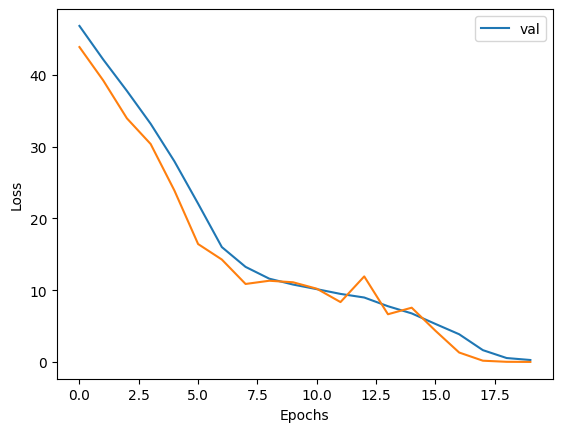

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 3
Epoch n0




2it [00:00, 15.13it/s]

4it [00:00, 13.36it/s]

6it [00:00, 13.75it/s]

8it [00:00, 13.93it/s]

10it [00:00, 12.92it/s]

12it [00:00, 13.27it/s]

15it [00:01, 13.30it/s]


2it [00:00, 35.27it/s][A

  5%|▌         | 1/20 [00:01<00:22,  1.19s/it]

0it [00:00, ?it/s]

2it [00:00, 16.04it/s]

TOTAL TRAIN LOSS 41.97106170654297
TOTAL EVAL LOSS 38.468698263168335
TRAIN 	1.129133701324463 secs
TRAIN accuracy : 0.007792207792207792
EVAL 	0.057904958724975586 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 13.93it/s]

6it [00:00, 14.17it/s]

8it [00:00, 14.34it/s]

10it [00:00, 12.96it/s]

12it [00:00, 13.12it/s]

15it [00:01, 13.25it/s]


2it [00:00, 32.50it/s][A

 10%|█         | 2/20 [00:02<00:21,  1.20s/it]

0it [00:00, ?it/s]

2it [00:00, 15.98it/s]

TOTAL TRAIN LOSS 36.32455635070801
TOTAL EVAL LOSS 33.30509305000305
TRAIN 	1.1328246593475342 secs
TRAIN accuracy : 0.08831168831168831
EVAL 	0.06256818771362305 secs
EVAL accuracy : 0.10437710437710437


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 13.66it/s]

6it [00:00, 13.98it/s]

8it [00:00, 14.32it/s]

10it [00:00, 13.00it/s]

12it [00:00, 13.28it/s]

15it [00:01, 13.31it/s]


2it [00:00, 34.84it/s][A

 15%|█▌        | 3/20 [00:03<00:20,  1.20s/it]

0it [00:00, ?it/s]

2it [00:00, 15.76it/s]

TOTAL TRAIN LOSS 30.912319501241047
TOTAL EVAL LOSS 26.050947904586792
TRAIN 	1.1277239322662354 secs
TRAIN accuracy : 0.11168831168831168
EVAL 	0.058502197265625 secs
EVAL accuracy : 0.11616161616161616


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 13.92it/s]

6it [00:00, 14.40it/s]

8it [00:00, 14.82it/s]

10it [00:00, 13.42it/s]

12it [00:00, 13.60it/s]

15it [00:01, 13.76it/s]


2it [00:00, 34.52it/s][A

 20%|██        | 4/20 [00:04<00:18,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 16.50it/s]

TOTAL TRAIN LOSS 25.43566433588664
TOTAL EVAL LOSS 21.198471784591675
TRAIN 	1.091257095336914 secs
TRAIN accuracy : 0.11688311688311688
EVAL 	0.05900216102600098 secs
EVAL accuracy : 0.11784511784511785


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 14.38it/s]

6it [00:00, 14.67it/s]

8it [00:00, 14.73it/s]

10it [00:00, 13.33it/s]

12it [00:00, 13.63it/s]

15it [00:01, 13.83it/s]


2it [00:00, 40.62it/s][A

 25%|██▌       | 5/20 [00:05<00:17,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 17.49it/s]

TOTAL TRAIN LOSS 18.96231508255005
TOTAL EVAL LOSS 15.839400887489319
TRAIN 	1.08577299118042 secs
TRAIN accuracy : 0.0987012987012987
EVAL 	0.05034184455871582 secs
EVAL accuracy : 0.09932659932659933


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 15.21it/s]

6it [00:00, 15.54it/s]

8it [00:00, 15.87it/s]

10it [00:00, 14.31it/s]

12it [00:00, 14.58it/s]

15it [00:01, 14.63it/s]


2it [00:00, 37.60it/s][A

 30%|███       | 6/20 [00:06<00:16,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 16.81it/s]

TOTAL TRAIN LOSS 13.753760973612467
TOTAL EVAL LOSS 12.29174256324768
TRAIN 	1.0263378620147705 secs
TRAIN accuracy : 0.11688311688311688
EVAL 	0.05423903465270996 secs
EVAL accuracy : 0.10942760942760943


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 14.82it/s]

6it [00:00, 15.27it/s]

8it [00:00, 15.53it/s]

10it [00:00, 14.14it/s]

12it [00:00, 14.45it/s]

15it [00:01, 14.50it/s]


2it [00:00, 40.17it/s][A

 35%|███▌      | 7/20 [00:08<00:14,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 16.86it/s]

TOTAL TRAIN LOSS 10.66380492846171
TOTAL EVAL LOSS 9.874744415283203
TRAIN 	1.0355300903320312 secs
TRAIN accuracy : 0.14285714285714285
EVAL 	0.05085611343383789 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 14.83it/s]

6it [00:00, 15.31it/s]

8it [00:00, 15.56it/s]

10it [00:00, 14.06it/s]

12it [00:00, 14.66it/s]

15it [00:01, 14.80it/s]


2it [00:00, 41.97it/s][A

 40%|████      | 8/20 [00:09<00:13,  1.11s/it]

0it [00:00, ?it/s]

2it [00:00, 18.42it/s]

TOTAL TRAIN LOSS 9.975730617841085
TOTAL EVAL LOSS 8.065358698368073
TRAIN 	1.0144708156585693 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.048689842224121094 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 16.03it/s]

6it [00:00, 16.45it/s]

8it [00:00, 16.76it/s]

10it [00:00, 15.16it/s]

12it [00:00, 15.45it/s]

15it [00:00, 15.53it/s]


2it [00:00, 41.69it/s][A

 45%|████▌     | 9/20 [00:10<00:11,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 18.12it/s]

TOTAL TRAIN LOSS 9.122588753700256
TOTAL EVAL LOSS 9.000009298324585
TRAIN 	0.9670252799987793 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04893612861633301 secs
EVAL accuracy : 0.14983164983164984


Epoch n9




4it [00:00, 15.70it/s]

6it [00:00, 16.19it/s]

8it [00:00, 16.60it/s]

10it [00:00, 14.96it/s]

12it [00:00, 15.32it/s]

15it [00:00, 15.25it/s]


2it [00:00, 39.15it/s][A

 50%|█████     | 10/20 [00:11<00:10,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 17.10it/s]

TOTAL TRAIN LOSS 8.329655210177103
TOTAL EVAL LOSS 7.080985754728317
TRAIN 	0.984745979309082 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.0522921085357666 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 14.86it/s]

6it [00:00, 15.43it/s]

8it [00:00, 15.79it/s]

10it [00:00, 14.19it/s]

12it [00:00, 14.53it/s]

15it [00:01, 14.69it/s]


2it [00:00, 37.01it/s][A

 55%|█████▌    | 11/20 [00:12<00:09,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.97it/s]

TOTAL TRAIN LOSS 6.556345999240875
TOTAL EVAL LOSS 7.123779654502869
TRAIN 	1.0220420360565186 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.05527091026306152 secs
EVAL accuracy : 0.14983164983164984


Epoch n11




4it [00:00, 14.84it/s]

6it [00:00, 15.37it/s]

8it [00:00, 15.70it/s]

10it [00:00, 14.22it/s]

12it [00:00, 14.43it/s]

15it [00:01, 14.61it/s]


2it [00:00, 43.10it/s][A

 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

0it [00:00, ?it/s]

2it [00:00, 17.73it/s]

TOTAL TRAIN LOSS 5.70713084936142
TOTAL EVAL LOSS 4.524761587381363
TRAIN 	1.0276970863342285 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.0477750301361084 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 15.60it/s]

6it [00:00, 16.29it/s]

8it [00:00, 16.53it/s]

10it [00:00, 14.94it/s]

12it [00:00, 15.26it/s]

15it [00:00, 15.35it/s]


2it [00:00, 42.62it/s][A

 65%|██████▌   | 13/20 [00:14<00:07,  1.06s/it]

0it [00:00, ?it/s]

2it [00:00, 17.99it/s]

TOTAL TRAIN LOSS 4.510978241761525
TOTAL EVAL LOSS 2.993261367082596
TRAIN 	0.9785869121551514 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04795074462890625 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n13




4it [00:00, 15.81it/s]

6it [00:00, 16.35it/s]

8it [00:00, 16.59it/s]

10it [00:00, 14.90it/s]

12it [00:00, 15.02it/s]

15it [00:01, 14.91it/s]


2it [00:00, 34.14it/s][A

 70%|███████   | 14/20 [00:15<00:06,  1.07s/it]

0it [00:00, ?it/s]

2it [00:00, 16.27it/s]

TOTAL TRAIN LOSS 3.0791505177815757
TOTAL EVAL LOSS 1.073720045387745
TRAIN 	1.007106065750122 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.059577226638793945 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.12it/s]

6it [00:00, 14.21it/s]

8it [00:00, 14.16it/s]

10it [00:00, 12.81it/s]

12it [00:00, 13.16it/s]

15it [00:01, 13.28it/s]


2it [00:00, 36.52it/s][A

 75%|███████▌  | 15/20 [00:16<00:05,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 16.30it/s]

TOTAL TRAIN LOSS 1.4625537941853206
TOTAL EVAL LOSS 0.19257624633610249
TRAIN 	1.1302692890167236 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.055831193923950195 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n15




4it [00:00, 13.94it/s]

6it [00:00, 14.13it/s]

8it [00:00, 14.35it/s]

10it [00:00, 13.18it/s]

12it [00:00, 13.21it/s]

15it [00:01, 13.37it/s]


2it [00:00, 34.32it/s][A

 80%|████████  | 16/20 [00:17<00:04,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 15.63it/s]

TOTAL TRAIN LOSS 0.6128897853195667
TOTAL EVAL LOSS 0.044971752213314176
TRAIN 	1.1233479976654053 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.059345245361328125 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n16




4it [00:00, 13.69it/s]

6it [00:00, 14.09it/s]

8it [00:00, 14.33it/s]

10it [00:00, 12.96it/s]

12it [00:00, 13.40it/s]

15it [00:01, 13.76it/s]


2it [00:00, 43.48it/s][A

 85%|████████▌ | 17/20 [00:18<00:03,  1.13s/it]

0it [00:00, ?it/s]

2it [00:00, 17.97it/s]

TOTAL TRAIN LOSS 0.2951223204533259
TOTAL EVAL LOSS 0.014298855676315725
TRAIN 	1.0917091369628906 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04717898368835449 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n17




4it [00:00, 15.76it/s]

6it [00:00, 16.20it/s]

8it [00:00, 16.49it/s]

10it [00:00, 14.85it/s]

12it [00:00, 15.25it/s]

15it [00:00, 15.37it/s]


2it [00:00, 43.10it/s][A

 90%|█████████ | 18/20 [00:20<00:02,  1.10s/it]

0it [00:00, ?it/s]

2it [00:00, 17.07it/s]

TOTAL TRAIN LOSS 0.21100480078409115
TOTAL EVAL LOSS 0.007066093385219574
TRAIN 	0.9770407676696777 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.04745316505432129 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n18




4it [00:00, 14.66it/s]

6it [00:00, 14.69it/s]

8it [00:00, 14.99it/s]

10it [00:00, 13.46it/s]

12it [00:00, 13.68it/s]

15it [00:01, 13.72it/s]


2it [00:00, 35.78it/s][A

 95%|█████████▌| 19/20 [00:21<00:01,  1.12s/it]

0it [00:00, ?it/s]

2it [00:00, 16.26it/s]

TOTAL TRAIN LOSS 0.13969779883821806
TOTAL EVAL LOSS 0.0036835248465649784
TRAIN 	1.0942978858947754 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.056982994079589844 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 
Epoch n19




4it [00:00, 13.91it/s]

6it [00:00, 14.35it/s]

8it [00:00, 14.69it/s]

10it [00:00, 13.26it/s]

12it [00:00, 13.32it/s]

15it [00:01, 13.37it/s]


2it [00:00, 35.26it/s][A

100%|██████████| 20/20 [00:22<00:00,  1.12s/it]

TOTAL TRAIN LOSS 0.11524035936842363
TOTAL EVAL LOSS 0.00264392961980775
TRAIN 	1.123058795928955 secs
TRAIN accuracy : 0.14805194805194805
EVAL 	0.05784106254577637 secs
EVAL accuracy : 0.14983164983164984


** ** * Saving fine - tuned model ** ** * 


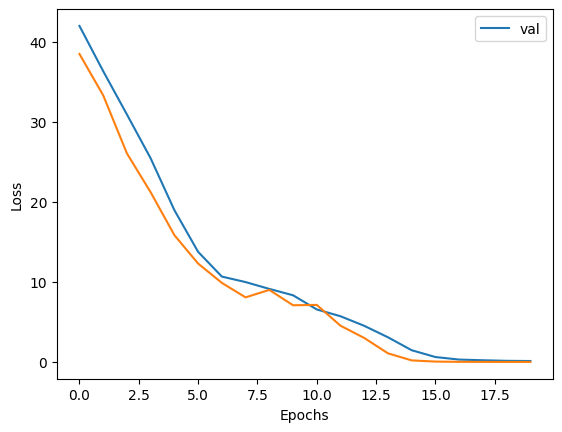

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 4
Epoch n0




2it [00:00, 13.29it/s]

4it [00:00, 13.01it/s]

6it [00:00, 12.70it/s]

8it [00:00, 12.94it/s]

9it [00:00, 10.88it/s]

11it [00:00, 11.49it/s]

13it [00:01, 12.78it/s]

15it [00:01, 12.65it/s]


2it [00:00, 45.32it/s][A

  5%|▌         | 1/20 [00:01<00:23,  1.24s/it]

0it [00:00, ?it/s]

2it [00:00, 16.88it/s]

TOTAL TRAIN LOSS 48.16927528381348
TOTAL EVAL LOSS 45.53425073623657
TRAIN 	1.1868698596954346 secs
TRAIN accuracy : 0.0
EVAL 	0.045156240463256836 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 15.93it/s]

6it [00:00, 15.34it/s]

8it [00:00, 15.50it/s]

10it [00:00, 13.39it/s]

12it [00:00, 14.11it/s]

15it [00:01, 13.90it/s]


2it [00:00, 47.01it/s][A

 10%|█         | 2/20 [00:02<00:21,  1.21s/it]

0it [00:00, ?it/s]

2it [00:00, 17.16it/s]

TOTAL TRAIN LOSS 43.650281270345054
TOTAL EVAL LOSS 41.57576322555542
TRAIN 	1.0799047946929932 secs
TRAIN accuracy : 0.0
EVAL 	0.04357576370239258 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 16.12it/s]

6it [00:00, 15.37it/s]

8it [00:00, 15.47it/s]

10it [00:00, 13.19it/s]

12it [00:00, 13.86it/s]

15it [00:01, 13.69it/s]


2it [00:00, 49.20it/s][A

 15%|█▌        | 3/20 [00:03<00:20,  1.19s/it]

0it [00:00, ?it/s]

2it [00:00, 16.67it/s]

TOTAL TRAIN LOSS 39.39311440785726
TOTAL EVAL LOSS 36.98142766952515
TRAIN 	1.0967950820922852 secs
TRAIN accuracy : 0.03740648379052369
EVAL 	0.04181218147277832 secs
EVAL accuracy : 0.038901601830663615


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 15.63it/s]

6it [00:00, 14.81it/s]

8it [00:00, 15.01it/s]

10it [00:00, 12.92it/s]

12it [00:00, 13.72it/s]

15it [00:01, 13.53it/s]


2it [00:00, 48.95it/s][A

 20%|██        | 4/20 [00:04<00:18,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 16.16it/s]

TOTAL TRAIN LOSS 35.13338247934977
TOTAL EVAL LOSS 33.19239854812622
TRAIN 	1.1095848083496094 secs
TRAIN accuracy : 0.06733167082294264
EVAL 	0.04209780693054199 secs
EVAL accuracy : 0.038901601830663615


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 15.43it/s]

6it [00:00, 14.77it/s]

8it [00:00, 14.90it/s]

10it [00:00, 12.87it/s]

12it [00:00, 13.75it/s]

15it [00:01, 13.59it/s]


2it [00:00, 45.46it/s][A

 25%|██▌       | 5/20 [00:05<00:17,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 16.93it/s]

TOTAL TRAIN LOSS 30.475135644276936
TOTAL EVAL LOSS 28.7222421169281
TRAIN 	1.1050081253051758 secs
TRAIN accuracy : 0.1172069825436409
EVAL 	0.045156002044677734 secs
EVAL accuracy : 0.10297482837528604


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 16.04it/s]

6it [00:00, 15.36it/s]

8it [00:00, 15.54it/s]

10it [00:00, 13.29it/s]

12it [00:00, 13.94it/s]

15it [00:01, 13.79it/s]


2it [00:00, 44.97it/s][A

 30%|███       | 6/20 [00:06<00:16,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.16it/s]

TOTAL TRAIN LOSS 25.900302171707153
TOTAL EVAL LOSS 23.3652663230896
TRAIN 	1.0892221927642822 secs
TRAIN accuracy : 0.1172069825436409
EVAL 	0.04549813270568848 secs
EVAL accuracy : 0.09839816933638444


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 16.06it/s]

6it [00:00, 15.40it/s]

8it [00:00, 15.53it/s]

10it [00:00, 13.24it/s]

12it [00:00, 13.88it/s]

15it [00:01, 13.66it/s]


2it [00:00, 44.09it/s][A

 35%|███▌      | 7/20 [00:08<00:15,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.32it/s]

TOTAL TRAIN LOSS 20.00403626759847
TOTAL EVAL LOSS 17.229522466659546
TRAIN 	1.0990750789642334 secs
TRAIN accuracy : 0.10972568578553615
EVAL 	0.04640007019042969 secs
EVAL accuracy : 0.10297482837528604


** ** * Saving fine - tuned model ** ** * 
Epoch n7




4it [00:00, 15.50it/s]

6it [00:00, 14.78it/s]

8it [00:00, 15.01it/s]

10it [00:00, 13.11it/s]

12it [00:00, 13.69it/s]

15it [00:01, 13.54it/s]


2it [00:00, 46.51it/s][A

 40%|████      | 8/20 [00:09<00:13,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.56it/s]

TOTAL TRAIN LOSS 15.495924671490988
TOTAL EVAL LOSS 13.601375818252563
TRAIN 	1.1093449592590332 secs
TRAIN accuracy : 0.11221945137157108
EVAL 	0.04419088363647461 secs
EVAL accuracy : 0.10297482837528604


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 15.58it/s]

6it [00:00, 14.85it/s]

8it [00:00, 15.06it/s]

10it [00:00, 12.96it/s]

12it [00:00, 13.83it/s]

15it [00:01, 13.64it/s]


2it [00:00, 46.44it/s][A

 45%|████▌     | 9/20 [00:10<00:12,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.57it/s]

TOTAL TRAIN LOSS 12.127256790796915
TOTAL EVAL LOSS 12.687167525291443
TRAIN 	1.1004388332366943 secs
TRAIN accuracy : 0.12718204488778054
EVAL 	0.044317007064819336 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 15.80it/s]

6it [00:00, 15.14it/s]

8it [00:00, 15.47it/s]

10it [00:00, 13.22it/s]

12it [00:00, 14.04it/s]

15it [00:01, 13.86it/s]


2it [00:00, 45.30it/s][A

 50%|█████     | 10/20 [00:11<00:11,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 16.70it/s]

TOTAL TRAIN LOSS 10.10440448919932
TOTAL EVAL LOSS 12.906875014305115
TRAIN 	1.0835559368133545 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04517030715942383 secs
EVAL accuracy : 0.14874141876430205


Epoch n10




4it [00:00, 15.79it/s]

6it [00:00, 15.20it/s]

8it [00:00, 15.43it/s]

10it [00:00, 13.18it/s]

12it [00:00, 13.83it/s]

15it [00:01, 13.65it/s]


2it [00:00, 47.88it/s][A

 55%|█████▌    | 11/20 [00:12<00:10,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 13.90it/s]

TOTAL TRAIN LOSS 9.944954335689545
TOTAL EVAL LOSS 10.8149054646492
TRAIN 	1.099902868270874 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04311990737915039 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 13.32it/s]

6it [00:00, 12.92it/s]

8it [00:00, 13.33it/s]

10it [00:00, 11.94it/s]

12it [00:00, 12.80it/s]

15it [00:01, 12.65it/s]


2it [00:00, 43.86it/s][A

 60%|██████    | 12/20 [00:13<00:09,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 15.82it/s]

TOTAL TRAIN LOSS 8.054416040579477
TOTAL EVAL LOSS 8.485617637634277
TRAIN 	1.186415195465088 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04665708541870117 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 15.11it/s]

6it [00:00, 14.60it/s]

8it [00:00, 14.80it/s]

10it [00:00, 12.80it/s]

12it [00:00, 13.68it/s]

15it [00:01, 13.47it/s]


2it [00:00, 48.38it/s][A

 65%|██████▌   | 13/20 [00:15<00:08,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 16.91it/s]

TOTAL TRAIN LOSS 7.148149410883586
TOTAL EVAL LOSS 6.792775392532349
TRAIN 	1.1146860122680664 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04238390922546387 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n13




4it [00:00, 16.06it/s]

6it [00:00, 15.38it/s]

8it [00:00, 15.27it/s]

10it [00:00, 12.30it/s]

12it [00:00, 13.05it/s]

15it [00:01, 13.17it/s]


2it [00:00, 41.06it/s][A

 70%|███████   | 14/20 [00:16<00:07,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 14.78it/s]

TOTAL TRAIN LOSS 6.3089122374852495
TOTAL EVAL LOSS 5.547823905944824
TRAIN 	1.1400890350341797 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.049765825271606445 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.51it/s]

6it [00:00, 14.19it/s]

8it [00:00, 14.74it/s]

10it [00:00, 12.80it/s]

12it [00:00, 13.53it/s]

15it [00:01, 13.41it/s]


2it [00:00, 43.29it/s][A

 75%|███████▌  | 15/20 [00:17<00:05,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 16.63it/s]

TOTAL TRAIN LOSS 3.8647614022096
TOTAL EVAL LOSS 2.544759064912796
TRAIN 	1.1194472312927246 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04744410514831543 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n15




4it [00:00, 15.49it/s]

6it [00:00, 14.84it/s]

8it [00:00, 15.04it/s]

10it [00:00, 12.83it/s]

12it [00:00, 13.61it/s]

15it [00:01, 13.41it/s]


2it [00:00, 45.03it/s][A

 80%|████████  | 16/20 [00:18<00:04,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 15.72it/s]

TOTAL TRAIN LOSS 2.2353949596484504
TOTAL EVAL LOSS 0.5167650245130062
TRAIN 	1.119891881942749 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.045411109924316406 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n16




4it [00:00, 14.98it/s]

6it [00:00, 14.45it/s]

8it [00:00, 14.67it/s]

10it [00:00, 12.81it/s]

12it [00:00, 13.66it/s]

15it [00:01, 13.50it/s]


2it [00:00, 44.76it/s][A

 85%|████████▌ | 17/20 [00:19<00:03,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 16.99it/s]

TOTAL TRAIN LOSS 0.9833492326239744
TOTAL EVAL LOSS 0.08274924475699663
TRAIN 	1.1125738620758057 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04590964317321777 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n17




4it [00:00, 16.01it/s]

6it [00:00, 15.22it/s]

8it [00:00, 15.35it/s]

10it [00:00, 13.27it/s]

12it [00:00, 14.11it/s]

15it [00:01, 13.80it/s]


2it [00:00, 37.12it/s][A

 90%|█████████ | 18/20 [00:20<00:02,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 15.51it/s]

TOTAL TRAIN LOSS 0.3901323278745015
TOTAL EVAL LOSS 0.01747456146404147
TRAIN 	1.0875990390777588 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.05499911308288574 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n18




4it [00:00, 15.13it/s]

6it [00:00, 14.59it/s]

8it [00:00, 14.68it/s]

10it [00:00, 12.50it/s]

12it [00:00, 12.72it/s]

15it [00:01, 12.91it/s]


2it [00:00, 39.97it/s][A

 95%|█████████▌| 19/20 [00:22<00:01,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 15.13it/s]

TOTAL TRAIN LOSS 0.20076578545073667
TOTAL EVAL LOSS 0.006956139113754034
TRAIN 	1.1630258560180664 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.05110502243041992 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 
Epoch n19




4it [00:00, 14.18it/s]

6it [00:00, 13.54it/s]

8it [00:00, 13.57it/s]

10it [00:00, 11.90it/s]

12it [00:00, 12.43it/s]

15it [00:01, 12.35it/s]


2it [00:00, 41.35it/s][A

100%|██████████| 20/20 [00:23<00:00,  1.17s/it]

TOTAL TRAIN LOSS 0.14513772943367562
TOTAL EVAL LOSS 0.0038061363738961518
TRAIN 	1.2156476974487305 secs
TRAIN accuracy : 0.14962593516209477
EVAL 	0.04941987991333008 secs
EVAL accuracy : 0.14874141876430205


** ** * Saving fine - tuned model ** ** * 


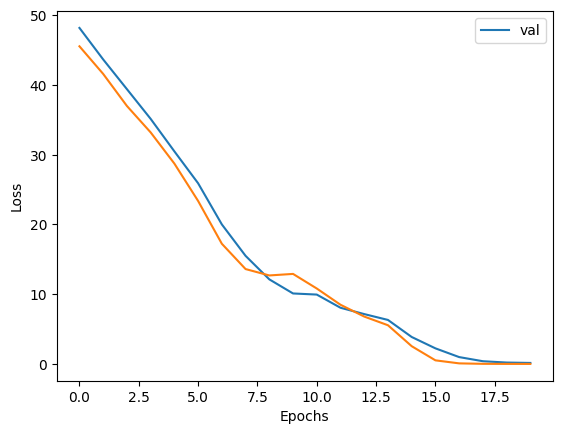

  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]


 Experiment 5
Epoch n0




2it [00:00, 14.42it/s]

4it [00:00, 12.67it/s]

6it [00:00, 11.60it/s]

8it [00:00, 12.60it/s]

10it [00:00, 13.18it/s]

12it [00:00, 13.38it/s]

15it [00:01, 13.47it/s]


2it [00:00, 39.88it/s][A

  5%|▌         | 1/20 [00:01<00:22,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 17.56it/s]

TOTAL TRAIN LOSS 46.602540016174316
TOTAL EVAL LOSS 44.00710105895996
TRAIN 	1.1149346828460693 secs
TRAIN accuracy : 0.0
EVAL 	0.051191091537475586 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n1




4it [00:00, 14.75it/s]

6it [00:00, 12.88it/s]

8it [00:00, 13.60it/s]

10it [00:00, 13.97it/s]

12it [00:00, 14.04it/s]

15it [00:01, 14.11it/s]


2it [00:00, 41.10it/s][A

 10%|█         | 2/20 [00:02<00:20,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.10it/s]

TOTAL TRAIN LOSS 42.231642723083496
TOTAL EVAL LOSS 39.831470251083374
TRAIN 	1.064450979232788 secs
TRAIN accuracy : 0.005249343832020997
EVAL 	0.04967093467712402 secs
EVAL accuracy : 0.0


** ** * Saving fine - tuned model ** ** * 
Epoch n2




4it [00:00, 14.34it/s]

6it [00:00, 12.54it/s]

8it [00:00, 13.26it/s]

10it [00:00, 13.55it/s]

12it [00:00, 13.76it/s]

15it [00:01, 13.79it/s]


2it [00:00, 36.43it/s][A

 15%|█▌        | 3/20 [00:03<00:19,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.30it/s]

TOTAL TRAIN LOSS 38.085278034210205
TOTAL EVAL LOSS 34.44066047668457
TRAIN 	1.0887930393218994 secs
TRAIN accuracy : 0.07086614173228346
EVAL 	0.05598306655883789 secs
EVAL accuracy : 0.12436974789915967


** ** * Saving fine - tuned model ** ** * 
Epoch n3




4it [00:00, 14.00it/s]

6it [00:00, 12.27it/s]

8it [00:00, 12.99it/s]

10it [00:00, 13.41it/s]

12it [00:00, 13.58it/s]

15it [00:01, 13.62it/s]


2it [00:00, 42.17it/s][A

 20%|██        | 4/20 [00:04<00:18,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.59it/s]

TOTAL TRAIN LOSS 33.480831146240234
TOTAL EVAL LOSS 29.83402729034424
TRAIN 	1.1027321815490723 secs
TRAIN accuracy : 0.10236220472440945
EVAL 	0.04848313331604004 secs
EVAL accuracy : 0.11932773109243698


** ** * Saving fine - tuned model ** ** * 
Epoch n4




4it [00:00, 14.01it/s]

6it [00:00, 12.36it/s]

8it [00:00, 13.22it/s]

10it [00:00, 13.77it/s]

12it [00:00, 13.80it/s]

15it [00:01, 13.80it/s]


2it [00:00, 39.22it/s][A

 25%|██▌       | 5/20 [00:05<00:17,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 17.59it/s]

TOTAL TRAIN LOSS 28.277639865875244
TOTAL EVAL LOSS 25.101826190948486
TRAIN 	1.0880608558654785 secs
TRAIN accuracy : 0.10236220472440945
EVAL 	0.05202007293701172 secs
EVAL accuracy : 0.1092436974789916


** ** * Saving fine - tuned model ** ** * 
Epoch n5




4it [00:00, 14.62it/s]

6it [00:00, 12.74it/s]

8it [00:00, 13.48it/s]

10it [00:00, 13.93it/s]

12it [00:00, 13.90it/s]

15it [00:01, 13.98it/s]


2it [00:00, 39.05it/s][A

 30%|███       | 6/20 [00:06<00:16,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 17.34it/s]

TOTAL TRAIN LOSS 22.614844640096027
TOTAL EVAL LOSS 17.555880546569824
TRAIN 	1.0745370388031006 secs
TRAIN accuracy : 0.10236220472440945
EVAL 	0.05226325988769531 secs
EVAL accuracy : 0.11428571428571428


** ** * Saving fine - tuned model ** ** * 
Epoch n6




4it [00:00, 14.40it/s]

6it [00:00, 12.57it/s]

8it [00:00, 12.77it/s]

10it [00:00, 12.52it/s]

12it [00:00, 12.48it/s]

15it [00:01, 12.80it/s]


2it [00:00, 34.05it/s][A

 35%|███▌      | 7/20 [00:08<00:15,  1.17s/it]

0it [00:00, ?it/s]



TOTAL TRAIN LOSS 16.761465152104694
TOTAL EVAL LOSS 13.11899185180664
TRAIN 	1.1728408336639404 secs
TRAIN accuracy : 0.11811023622047244
EVAL 	0.059777021408081055 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n7


2it [00:00, 15.04it/s]

4it [00:00, 13.01it/s]

6it [00:00, 11.55it/s]

8it [00:00, 12.51it/s]

10it [00:00, 13.05it/s]

12it [00:00, 13.31it/s]

15it [00:01, 13.20it/s]


2it [00:00, 38.14it/s][A

 40%|████      | 8/20 [00:09<00:14,  1.18s/it]

0it [00:00, ?it/s]

2it [00:00, 16.96it/s]

TOTAL TRAIN LOSS 13.179985562960306
TOTAL EVAL LOSS 11.778773069381714
TRAIN 	1.137416124343872 secs
TRAIN accuracy : 0.14435695538057744
EVAL 	0.05362105369567871 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n8




4it [00:00, 14.17it/s]

6it [00:00, 12.29it/s]

8it [00:00, 13.18it/s]

10it [00:00, 13.65it/s]

12it [00:00, 13.71it/s]

15it [00:01, 13.82it/s]


2it [00:00, 38.66it/s][A

 45%|████▌     | 9/20 [00:10<00:12,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 17.64it/s]

TOTAL TRAIN LOSS 11.652229110399881
TOTAL EVAL LOSS 9.59326446056366
TRAIN 	1.0862948894500732 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05274605751037598 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n9




4it [00:00, 14.49it/s]

6it [00:00, 12.64it/s]

8it [00:00, 13.40it/s]

10it [00:00, 13.64it/s]

12it [00:00, 13.74it/s]

15it [00:01, 13.83it/s]


2it [00:00, 38.94it/s][A

 50%|█████     | 10/20 [00:11<00:11,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.15it/s]

TOTAL TRAIN LOSS 9.876629511515299
TOTAL EVAL LOSS 8.33202600479126
TRAIN 	1.0857961177825928 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05258488655090332 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n10




4it [00:00, 14.35it/s]

6it [00:00, 12.47it/s]

8it [00:00, 13.09it/s]

10it [00:00, 13.51it/s]

12it [00:00, 13.58it/s]

15it [00:01, 13.58it/s]


2it [00:00, 40.23it/s][A

 55%|█████▌    | 11/20 [00:12<00:10,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.87it/s]

TOTAL TRAIN LOSS 9.262086272239685
TOTAL EVAL LOSS 8.14855307340622
TRAIN 	1.106015920639038 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05080604553222656 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n11




4it [00:00, 14.23it/s]

6it [00:00, 12.42it/s]

8it [00:00, 13.14it/s]

10it [00:00, 13.55it/s]

12it [00:00, 13.57it/s]

15it [00:01, 13.53it/s]


2it [00:00, 37.73it/s][A

 60%|██████    | 12/20 [00:13<00:09,  1.17s/it]

0it [00:00, ?it/s]

2it [00:00, 17.39it/s]

TOTAL TRAIN LOSS 9.22084641456604
TOTAL EVAL LOSS 6.759881675243378
TRAIN 	1.1096148490905762 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05406308174133301 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n12




4it [00:00, 14.59it/s]

6it [00:00, 12.66it/s]

8it [00:00, 13.40it/s]

10it [00:00, 13.84it/s]

12it [00:00, 13.94it/s]

15it [00:01, 14.03it/s]


2it [00:00, 39.19it/s][A

 65%|██████▌   | 13/20 [00:15<00:08,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 15.77it/s]

TOTAL TRAIN LOSS 7.802872618039449
TOTAL EVAL LOSS 7.016428112983704
TRAIN 	1.0705211162567139 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.0520777702331543 secs
EVAL accuracy : 0.1495798319327731


Epoch n13




4it [00:00, 13.28it/s]

6it [00:00, 11.77it/s]

8it [00:00, 12.37it/s]

10it [00:00, 12.93it/s]

12it [00:00, 13.29it/s]

15it [00:01, 13.32it/s]


2it [00:00, 37.66it/s][A

 70%|███████   | 14/20 [00:16<00:06,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 17.51it/s]

TOTAL TRAIN LOSS 7.120814859867096
TOTAL EVAL LOSS 5.851656198501587
TRAIN 	1.1271789073944092 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05413484573364258 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n14




4it [00:00, 14.41it/s]

6it [00:00, 12.52it/s]

8it [00:00, 13.23it/s]

10it [00:00, 13.57it/s]

12it [00:00, 13.56it/s]

15it [00:01, 13.65it/s]


2it [00:00, 36.99it/s][A

 75%|███████▌  | 15/20 [00:17<00:05,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.15it/s]

TOTAL TRAIN LOSS 5.793276071548462
TOTAL EVAL LOSS 4.413490146398544
TRAIN 	1.099992275238037 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.05514693260192871 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n15




4it [00:00, 14.04it/s]

6it [00:00, 12.47it/s]

8it [00:00, 13.13it/s]

10it [00:00, 13.55it/s]

12it [00:00, 13.65it/s]

15it [00:01, 13.80it/s]


2it [00:00, 37.62it/s][A

 80%|████████  | 16/20 [00:18<00:04,  1.16s/it]

0it [00:00, ?it/s]

2it [00:00, 16.55it/s]

TOTAL TRAIN LOSS 4.0971573193868
TOTAL EVAL LOSS 1.9889848679304123
TRAIN 	1.087622880935669 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.054407358169555664 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n16




4it [00:00, 14.24it/s]

6it [00:00, 12.51it/s]

8it [00:00, 13.33it/s]

10it [00:00, 13.78it/s]

12it [00:00, 13.93it/s]

15it [00:01, 13.93it/s]


2it [00:00, 41.33it/s][A

 85%|████████▌ | 17/20 [00:19<00:03,  1.15s/it]

0it [00:00, ?it/s]

2it [00:00, 16.47it/s]

TOTAL TRAIN LOSS 2.1590253909428916
TOTAL EVAL LOSS 0.45328810811042786
TRAIN 	1.0780160427093506 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.049571990966796875 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n17




4it [00:00, 13.80it/s]

6it [00:00, 12.08it/s]

8it [00:00, 12.44it/s]

10it [00:00, 12.54it/s]

12it [00:01, 12.46it/s]

15it [00:01, 12.68it/s]


2it [00:00, 32.14it/s][A

 90%|█████████ | 18/20 [00:20<00:02,  1.18s/it]

0it [00:00, ?it/s]

TOTAL TRAIN LOSS 0.8931945512692133
TOTAL EVAL LOSS 0.057597237173467875
TRAIN 	1.184002161026001 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.06328082084655762 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n18




2it [00:00, 14.34it/s]

4it [00:00, 12.55it/s]

6it [00:00, 11.45it/s]

8it [00:00, 11.84it/s]

10it [00:00, 12.09it/s]

12it [00:01, 12.18it/s]

15it [00:01, 12.28it/s]


2it [00:00, 30.94it/s][A

 95%|█████████▌| 19/20 [00:22<00:01,  1.22s/it]

0it [00:00, ?it/s]

2it [00:00, 15.96it/s]

TOTAL TRAIN LOSS 0.33383079804480076
TOTAL EVAL LOSS 0.0164041668176651
TRAIN 	1.222506046295166 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.0657188892364502 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 
Epoch n19




4it [00:00, 13.45it/s]

6it [00:00, 11.76it/s]

8it [00:00, 12.21it/s]

10it [00:00, 12.45it/s]

12it [00:01, 12.45it/s]

15it [00:01, 12.58it/s]


2it [00:00, 32.31it/s][A

100%|██████████| 20/20 [00:23<00:00,  1.18s/it]

TOTAL TRAIN LOSS 0.17888410575687885
TOTAL EVAL LOSS 0.006990492984186858
TRAIN 	1.1936888694763184 secs
TRAIN accuracy : 0.14960629921259844
EVAL 	0.06296658515930176 secs
EVAL accuracy : 0.1495798319327731


** ** * Saving fine - tuned model ** ** * 


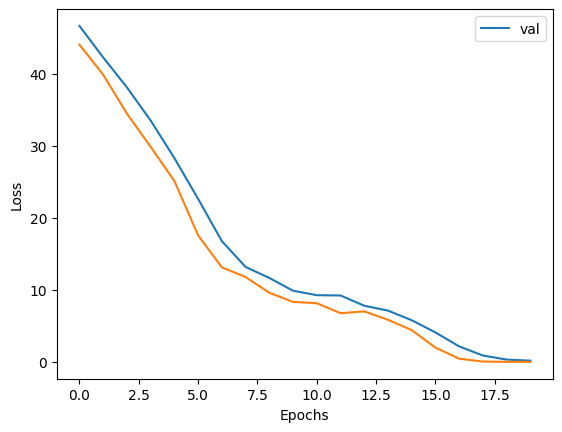

100%|██████████| 5/5 [01:55<00:00, 23.10s/it]


In [59]:
df = experiment(num_experiments=5)

In [60]:
df

,Experiment,Model,Metric,Score
0,1,GT_BERT,Val Accuracy,0.147992
1,1,GT_BERT,Train Loss,0.739967
2,1,GT_BERT,Val Loss,0.084676
3,1,GT_BERT,Train Time,1.100722
4,1,GT_BERT,Val Time,0.049578
5,2,GT_BERT,Val Accuracy,0.149635
6,2,GT_BERT,Train Loss,0.274520
7,2,GT_BERT,Val Loss,0.008119
8,2,GT_BERT,Train Time,1.012588
9,2,GT_BERT,Val Time,0.045859


In [61]:
# Group by Model and Metric and calculate average and standard deviation
result_df = df.groupby(['Model', 'Metric']).agg({'Score': ['mean', 'std']}).reset_index()

# Rename columns for clarity
result_df.columns = ['Model', 'Metric', 'Average Score', 'Standard Deviation']

result_df['Average Score'] = result_df['Average Score'].round(2)
result_df['Standard Deviation'] = result_df['Standard Deviation'].round(2)

# save the result
result_df.to_csv(path_results + 'dataframes/' + 'GT_behrt_results_pretraining_1_global.csv')

In [62]:
# print results
result_df

,Model,Metric,Average Score,Standard Deviation
0,GT_BERT,Train Loss,0.29,0.26
1,GT_BERT,Train Time,1.13,0.08
2,GT_BERT,Val Accuracy,0.15,0.00
3,GT_BERT,Val Loss,0.02,0.04
4,GT_BERT,Val Time,0.05,0.01


#################################################### Saving ####################################################

In [ ]:
#Pour charger les parametre dans un nouveau modele:
#new_gnn = GraphTransformer(conf)  # Créez une nouvelle instance de GraphTransformer
#new_gnn.load_state_dict(torch.load('../../data/'+'GraphTransformer_pretrain_1' + '.pch'))